# Homework 2
Christopher Beam

800927393

## Problem 1

In [1]:
# Setup
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Get dataset
df = pd.read_csv("../datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Split the dataset
Y1 = df.values[:,8]
X1 = df.values[:,:8]
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2)

In [4]:
tempOnes1_train = np.ones((len(Y1_train), 1))
tempOnes1_test = np.ones((len(Y1_test),1))
iterations = 100

In [5]:
# Scale the input
X1_scaler = StandardScaler()
X1_scaler.fit(X1_train)
X1_train_std = X1_scaler.transform(X1_train)
X1_test_std = X1_scaler.transform(X1_test)
X1_train_std = np.hstack((tempOnes1_train, X1_train_std))
X1_test_std = np.hstack((tempOnes1_test, X1_test_std))

In [6]:
# Log Regression and Gradient_descent
def h_func(X,theta):
    return 1/(1+np.exp(-X.dot(theta)))

def logReg(X, Y, theta):
    H = h_func(X,theta)
    errors = -Y*np.log(H)-(1-Y)*np.log(1-H)
    return np.mean(errors)

def gradDes_paramPen(X_train, Y_train, theta, alpha, iterations, beta):
    costArray = np.zeros(iterations)
    for i in range(iterations):
        pred = h_func(X_train,theta)
        errors = np.subtract(pred, Y_train)
        delta = (alpha / len(Y_train)) * (X_train.transpose().dot(errors))
        delta[1:] = delta[1:] + beta * theta[1:]
        theta = theta - delta
        costArray[i] = logReg(X_train, Y_train, theta)
    return theta, costArray

def gradDes_paramPen_kFold(X_train, Y_train, theta, alpha, iterations, beta, K):
    costArray = np.zeros(iterations)
    valArray = np.zeros(iterations)
    sliceSize = round(len(X_train)/5)

    for i in range(iterations):
        tempCost = 0
        tempVal = 0
        for k in range(K):
            sliceCond = np.zeros(len(X_train), dtype=bool)
            sliceCond[k*sliceSize:(k+1)*sliceSize] = True
            x_val = X_train[np.where(sliceCond == True), :]
            x_train = X_train[np.where(sliceCond == False), :]
            y_val = Y_train[np.where(sliceCond == True)]
            y_train = Y_train[np.where(sliceCond == False)]
            x_val = x_val.reshape(x_val.shape[1:])
            x_train = x_train.reshape(x_train.shape[1:])

            pred = h_func(x_train,theta)
            errors = np.subtract(pred, y_train)
            delta = (alpha / len(y_train)) * (x_train.transpose().dot(errors))

            delta[1:] = delta[1:] + beta * theta[1:]
            theta = theta - delta
            tempCost += logReg(x_train, y_train, theta)
            tempVal += logReg(x_val, y_val, theta)

        costArray[i] = tempCost/K
        valArray[i] = tempVal/K

    return theta, costArray, valArray


Learn rate with lowest error is 0.10, min error = 0.519798
Accuracy: 0.75
Precision: 0.77
Recall: 0.87


Text(0.5, 427.9555555555555, 'Predicted Label')

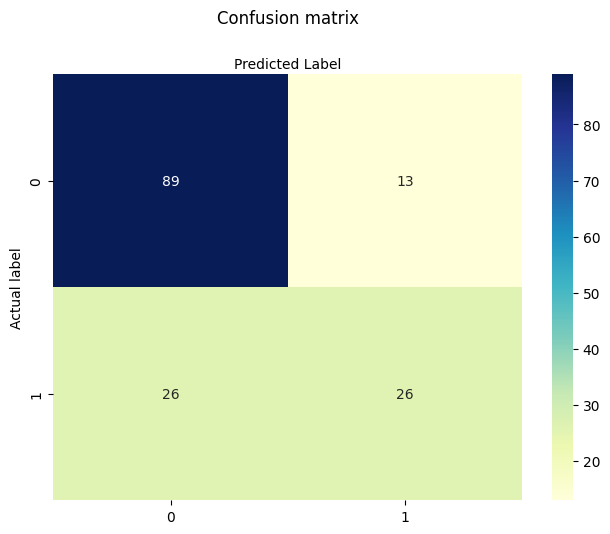

In [7]:
# Perform regression

learnSize = 20
learnRange = np.linspace(0.01, 0.1, learnSize, endpoint=True)
errorOut = []
thetaArray = []
lossArray = []
for learnRate in learnRange:
    theta_x1 = np.zeros(9)
    theta_x1, loss = gradDes_paramPen(X1_train_std, Y1_train, theta_x1, learnRate, iterations, 0)
    lossArray.append(loss)
    thetaArray.append(theta_x1)
    errorOut.append(logReg(X1_test_std, Y1_test, theta_x1))

idx = np.argmin(errorOut)
print("Learn rate with lowest error is {:.2f}, min error = {:f}".format(learnRange[idx], np.min(errorOut)))

H = h_func(X1_test_std, thetaArray[idx])
cnf_mat = confusion_matrix(Y1_test, H.round())

print("Accuracy: {:.2f}".format((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat)))
print("Precision: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1])))
print("Recall: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1])))

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted Label")

## Problem 2
### K = 5

Learn rate with lowest error is 0.02, min error = 0.519294
Accuracy: 0.75
Precision: 0.78
Recall: 0.88


Text(0.5, 427.9555555555555, 'Predicted Label')

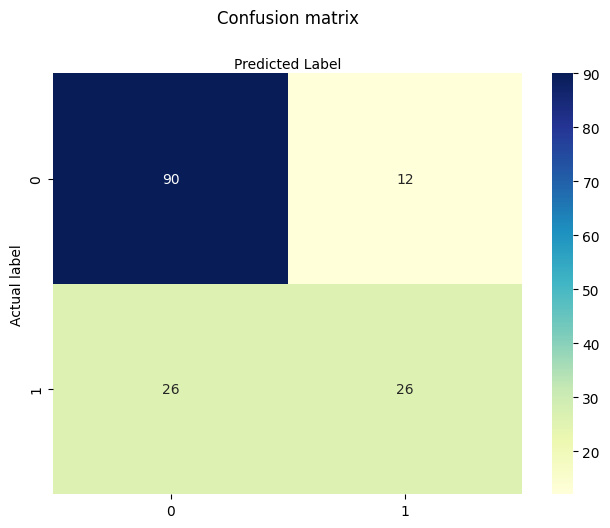

In [8]:
# Perform regression

learnSize = 20
learnRange = np.linspace(0.01, 0.1, learnSize, endpoint=True)
errorOut = []
thetaArray = []
lossArray = []
valArray = []
for learnRate in learnRange:
    theta_x2a = np.zeros(9)
    theta_x2a, loss, val = gradDes_paramPen_kFold(X1_train_std, Y1_train, theta_x2a, learnRate, iterations, 0, 5)
    lossArray.append(loss)
    thetaArray.append(theta_x2a)
    errorOut.append(logReg(X1_test_std, Y1_test, theta_x2a))

idx = np.argmin(errorOut)
print("Learn rate with lowest error is {:.2f}, min error = {:f}".format(learnRange[idx], np.min(errorOut)))

H = h_func(X1_test_std, thetaArray[idx])
cnf_mat = confusion_matrix(Y1_test, H.round())

print("Accuracy: {:.2f}".format((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat)))
print("Precision: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1])))
print("Recall: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1])))

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted Label")

### K = 10

/home/grey/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/grey/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Learn rate with lowest error is 0.01, min error = 0.519583
Accuracy: 0.76
Precision: 0.77
Recall: 0.88


Text(0.5, 427.9555555555555, 'Predicted Label')

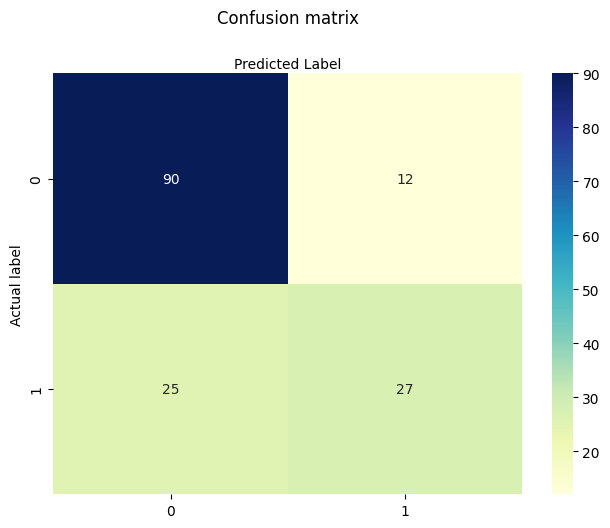

In [9]:
# Perform regression

learnSize = 20
learnRange = np.linspace(0.01, 0.1, learnSize, endpoint=True)
errorOut = []
thetaArray = []
lossArray = []
valArray = []
for learnRate in learnRange:
    theta_x2b = np.zeros(9)
    theta_x2b, loss, val = gradDes_paramPen_kFold(X1_train_std, Y1_train, theta_x2b, learnRate, iterations, 0, 10)
    lossArray.append(loss)
    thetaArray.append(theta_x2b)
    errorOut.append(logReg(X1_test_std, Y1_test, theta_x2b))

idx = np.argmin(errorOut)
print("Learn rate with lowest error is {:.2f}, min error = {:f}".format(learnRange[idx], np.min(errorOut)))

H = h_func(X1_test_std, thetaArray[idx])
cnf_mat = confusion_matrix(Y1_test, H.round())

print("Accuracy: {:.2f}".format((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat)))
print("Precision: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1])))
print("Recall: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1])))

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted Label")

## Problem 3

In [10]:
# Get dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [11]:
# Split the dataset
Y2 = data.target
X2 = data.data
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2)

In [12]:
tempOnes2_train = np.ones((len(Y2_train), 1))
tempOnes2_test = np.ones((len(Y2_test),1))

In [13]:
# Scale the input
X2_scaler = StandardScaler()
X2_scaler.fit(X2_train)
X2_train_std = X2_scaler.transform(X2_train)
X2_test_std = X2_scaler.transform(X2_test)
X2_train_std = np.hstack((tempOnes2_train, X2_train_std))
X2_test_std = np.hstack((tempOnes2_test, X2_test_std))

### Part 1

Learn rate with lowest error is 0.10, min error = 0.092846
Accuracy: 0.99
Precision: 0.35
Recall: 0.97


Text(0.5, 427.9555555555555, 'Predicted Label')

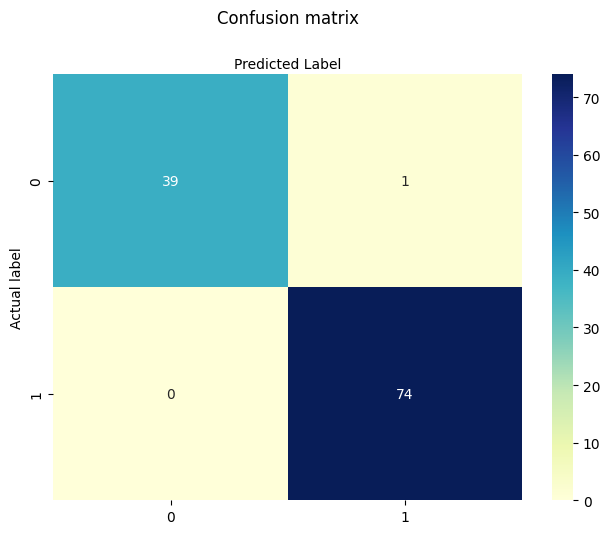

In [14]:
# Perform regression

learnSize = 20
learnRange = np.linspace(0.01, 0.1, learnSize, endpoint=True)
errorOut = []
thetaArray = []
lossArray = []
for learnRate in learnRange:
    theta_x3a = np.zeros(31)
    theta_x3a, loss = gradDes_paramPen(X2_train_std, Y2_train, theta_x3a, learnRate, iterations, 0)
    lossArray.append(loss)
    thetaArray.append(theta_x3a)
    errorOut.append(logReg(X2_test_std, Y2_test, theta_x3a))

idx = np.argmin(errorOut)
print("Learn rate with lowest error is {:.2f}, min error = {:f}".format(learnRange[idx], np.min(errorOut)))

H = h_func(X2_test_std, thetaArray[idx])
cnf_mat = confusion_matrix(Y2_test, H.round())

print("Accuracy: {:.2f}".format((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat)))
print("Precision: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1])))
print("Recall: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1])))

class_names = data.target_names
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted Label")

### Part 2

Learn rate with lowest error is 0.10, min error = 0.386639
Accuracy: 0.91
Precision: 0.30
Recall: 0.78


Text(0.5, 427.9555555555555, 'Predicted Label')

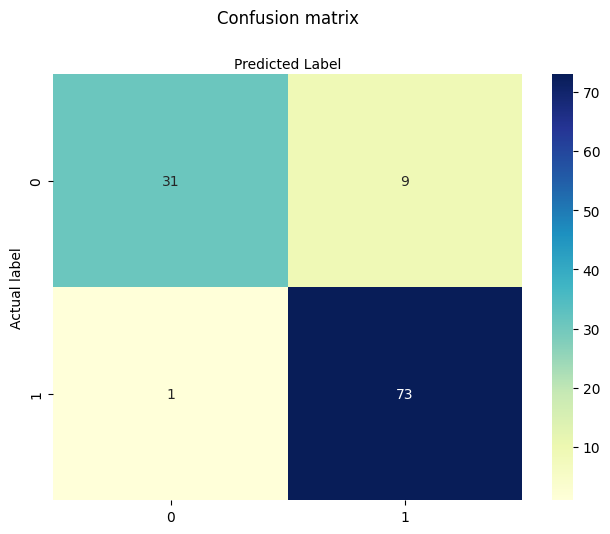

In [15]:
# Perform regression

learnSize = 20
learnRange = np.linspace(0.01, 0.1, learnSize, endpoint=True)
errorOut = []
thetaArray = []
lossArray = []
for learnRate in learnRange:
    theta_x3b = np.zeros(31)
    theta_x3b, loss = gradDes_paramPen(X2_train_std, Y2_train, theta_x3b, learnRate, iterations, 0.25)
    lossArray.append(loss)
    thetaArray.append(theta_x3b)
    errorOut.append(logReg(X2_test_std, Y2_test, theta_x3b))

idx = np.argmin(errorOut)
print("Learn rate with lowest error is {:.2f}, min error = {:f}".format(learnRange[idx], np.min(errorOut)))

H = h_func(X2_test_std, thetaArray[idx])
cnf_mat = confusion_matrix(Y2_test, H.round())

print("Accuracy: {:.2f}".format((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat)))
print("Precision: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1])))
print("Recall: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1])))

class_names = data.target_names
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted Label")

## Problem 4

### Part 1

#### K = 5

Learn rate with lowest error is 0.01, min error = 0.386639
Accuracy: 0.98
Precision: 0.35
Recall: 0.97


Text(0.5, 427.9555555555555, 'Predicted Label')

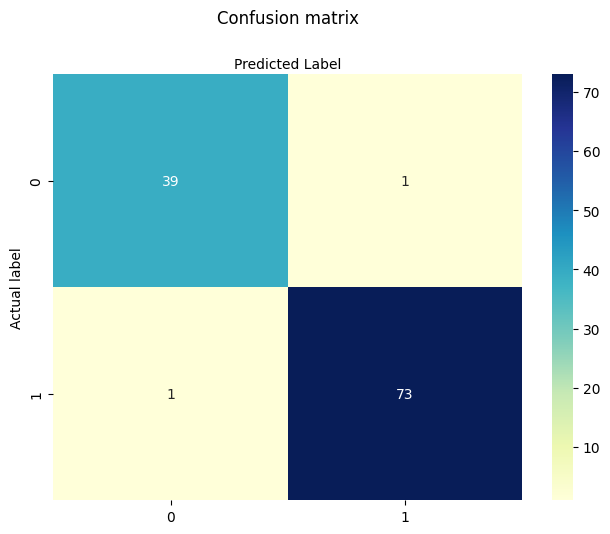

In [16]:
# Perform regression

learnSize = 20
learnRange = np.linspace(0.01, 0.1, learnSize, endpoint=True)
errorOut = []
thetaArray = []
lossArray = []
for learnRate in learnRange:
    theta_x41a = np.zeros(31)
    theta_x41a, loss, val = gradDes_paramPen_kFold(X2_train_std, Y2_train, theta_x41a, learnRate, iterations, 0, 5)
    lossArray.append(loss)
    thetaArray.append(theta_x41a)
    errorOut.append(logReg(X2_test_std, Y2_test, theta_x3b))

idx = np.argmin(errorOut)
print("Learn rate with lowest error is {:.2f}, min error = {:f}".format(learnRange[idx], np.min(errorOut)))

H = h_func(X2_test_std, thetaArray[idx])
cnf_mat = confusion_matrix(Y2_test, H.round())

print("Accuracy: {:.2f}".format((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat)))
print("Precision: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1])))
print("Recall: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1])))

class_names = data.target_names
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted Label")

#### K = 10

/home/grey/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/grey/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Learn rate with lowest error is 0.01, min error = 0.386639
Accuracy: 0.99
Precision: 0.35
Recall: 0.97


Text(0.5, 427.9555555555555, 'Predicted Label')

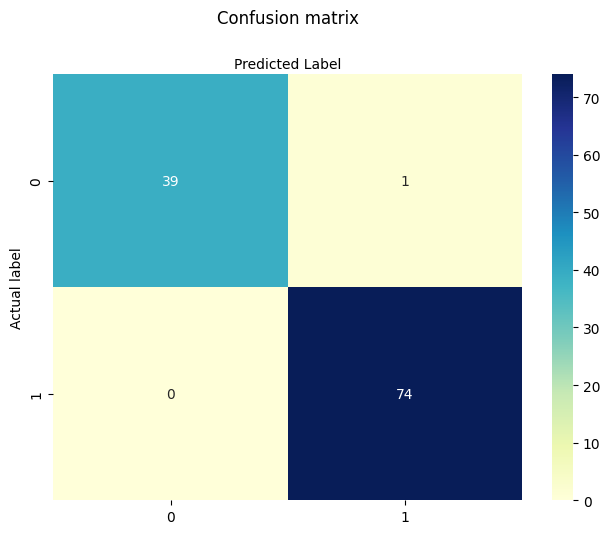

In [17]:
# Perform regression

learnSize = 20
learnRange = np.linspace(0.01, 0.1, learnSize, endpoint=True)
errorOut = []
thetaArray = []
lossArray = []
for learnRate in learnRange:
    theta_x41a = np.zeros(31)
    theta_x41a, loss, val = gradDes_paramPen_kFold(X2_train_std, Y2_train, theta_x41a, learnRate, iterations, 0, 10)
    lossArray.append(loss)
    thetaArray.append(theta_x41a)
    errorOut.append(logReg(X2_test_std, Y2_test, theta_x3b))

idx = np.argmin(errorOut)
print("Learn rate with lowest error is {:.2f}, min error = {:f}".format(learnRange[idx], np.min(errorOut)))

H = h_func(X2_test_std, thetaArray[idx])
cnf_mat = confusion_matrix(Y2_test, H.round())

print("Accuracy: {:.2f}".format((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat)))
print("Precision: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1])))
print("Recall: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1])))

class_names = data.target_names
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted Label")

### Part 2

#### K = 5

Learn rate with lowest error is 0.01, min error = 0.386639
Accuracy: 0.80
Precision: 0.19
Recall: 0.42


Text(0.5, 427.9555555555555, 'Predicted Label')

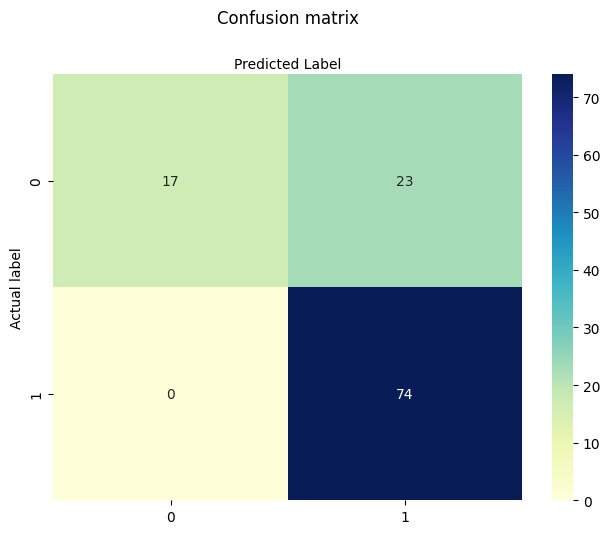

In [18]:
# Perform regression

learnSize = 20
learnRange = np.linspace(0.01, 0.1, learnSize, endpoint=True)
errorOut = []
thetaArray = []
lossArray = []
for learnRate in learnRange:
    theta_x41a = np.zeros(31)
    theta_x41a, loss, val = gradDes_paramPen_kFold(X2_train_std, Y2_train, theta_x41a, learnRate, iterations, 0.1, 5)
    lossArray.append(loss)
    thetaArray.append(theta_x41a)
    errorOut.append(logReg(X2_test_std, Y2_test, theta_x3b))

idx = np.argmin(errorOut)
print("Learn rate with lowest error is {:.2f}, min error = {:f}".format(learnRange[idx], np.min(errorOut)))

H = h_func(X2_test_std, thetaArray[idx])
cnf_mat = confusion_matrix(Y2_test, H.round())

print("Accuracy: {:.2f}".format((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat)))
print("Precision: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1])))
print("Recall: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1])))

class_names = data.target_names
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted Label")

#### K = 10

/home/grey/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/grey/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Learn rate with lowest error is 0.01, min error = 0.386639
Accuracy: 0.76
Precision: 0.15
Recall: 0.33


Text(0.5, 427.9555555555555, 'Predicted Label')

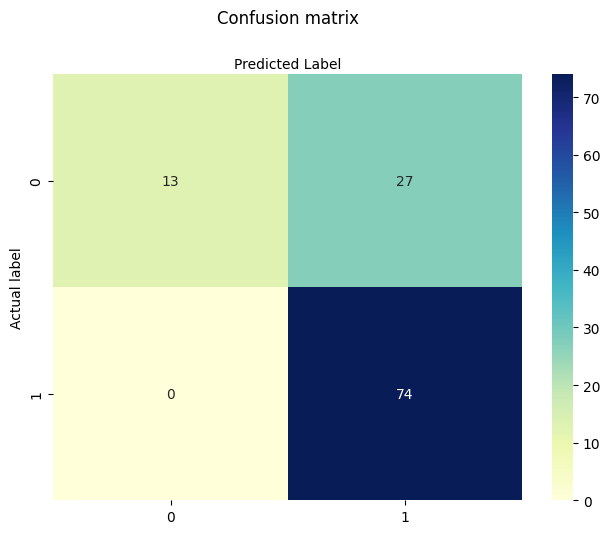

In [19]:
# Perform regression

learnSize = 20
learnRange = np.linspace(0.01, 0.1, learnSize, endpoint=True)
errorOut = []
thetaArray = []
lossArray = []
for learnRate in learnRange:
    theta_x41a = np.zeros(31)
    theta_x41a, loss, val = gradDes_paramPen_kFold(X2_train_std, Y2_train, theta_x41a, learnRate, iterations, 0.1, 10)
    lossArray.append(loss)
    thetaArray.append(theta_x41a)
    errorOut.append(logReg(X2_test_std, Y2_test, theta_x3b))

idx = np.argmin(errorOut)
print("Learn rate with lowest error is {:.2f}, min error = {:f}".format(learnRange[idx], np.min(errorOut)))

H = h_func(X2_test_std, thetaArray[idx])
cnf_mat = confusion_matrix(Y2_test, H.round())

print("Accuracy: {:.2f}".format((cnf_mat[0,0] + cnf_mat[1,1]) / np.sum(cnf_mat)))
print("Precision: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[1,1])))
print("Recall: {:.2f}".format(cnf_mat[0,0]/(cnf_mat[0,0] + cnf_mat[0,1])))

class_names = data.target_names
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted Label")